# Previsão Notas de Matemática

In [172]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [83]:
df = pd.read_csv('train.csv')

In [84]:
df.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,NO_ENTIDADE_CERTIFICACAO,CO_UF_ENTIDADE_CERTIFICACAO,SG_UF_ENTIDADE_CERTIFICACAO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,4314902,Porto Alegre,43,RS,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,ABACCABDBEDEDEEDDDBBBDAABABECDCCCAAABCBEEABCA,BBEBCAEBCEDBDDEBCACDBCBDABDDCDBEDCEAEABCAADAC,99999DCABCABCBBCADBCBBABAEADBEEBEDAAABAEAECCBB...,AECCCBABDCADDBCBCCADADBBAADEBCEEBABCDDEAABCAA,1,BCADBCEDCCBADBDCADBEBDBEADCCAEACDBEDBCACAEBEE,BCBCCADCCBEDDBEEADBDCECCBBECAEEDDADCDDACAADBA,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2304707,Granja,23,CE,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,EDAAABDABADBCCAEDCDDECABADBEECBBAEEDCABCAABBC,ADCAABAADCEDAACDACEEDACBDCBACEDEDBACAADADABDC,99999ACBACDBDBCEADDAEEADCCEACEEDBECAAAACBECDAC...,AEDACBDECEDAEEAEDDEBDECDCECACADCACACAABDACEAB,1,EBEECADBCABECDDBEADCCABDEABEBCADBADDCCCEDBBCA,DCECBAAADCBBECAEDCEDDACCBDDACEDDBADBCADBCBCEE,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEA

In [85]:
df.shape

(13730, 167)

In [146]:
df_test = pd.read_csv('test.csv')
df_test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,464.8,443.5,431.8,0,1.0,120.0,80.0,80.0,100.0,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,391.1,491.1,548.0,1,1.0,120.0,120.0,120.0,120.0,100.0,580.0,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,3.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,595.9,622.7,613.6,0,1.0,80.0,40.0,40.0,80.0,80.0,320.0,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,592.9,492.6,571.4,1,1.0,100.0,80.0,60.0,80.0,0.0,320.0,D,H,H,C,B,A,NaN,A


In [149]:
df_test2 = df_test[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA']].fillna(0)

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Columns: 167 entries, Unnamed: 0 to Q050
dtypes: float64(28), int64(79), object(60)
memory usage: 17.5+ MB


In [116]:
X = df.drop(columns="NU_NOTA_MT")
X_num = X.select_dtypes(include=['float64', 'int64'])
y = df["NU_NOTA_MT"].fillna(0)

In [89]:
X_num.drop(['Unnamed: 0','NU_ANO','CO_MUNICIPIO_RESIDENCIA','TP_ESTADO_CIVIL','TP_COR_RACA','TP_NACIONALIDADE',
           'CO_MUNICIPIO_NASCIMENTO','CO_ESCOLA','CO_MUNICIPIO_ESC','CO_MUNICIPIO_PROVA'], axis=1, inplace=True)

c:\users\raissa\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [104]:
X_num = X_num.fillna(0)

In [113]:
X_num.reset_index(drop=True, inplace=True)

In [124]:
estimator = xgb.XGBRegressor()
selector = RFE(estimator, n_features_to_select=7, step=1)
selector = selector.fit(X_num, y)

In [125]:
# Features selecionadas a partir de todas as variaveis numericas
X_num.iloc[0, selector.get_support(indices = True)].index

Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'Q029', 'Q033', 'Q037'], dtype='object')

In [122]:
# Features selecionadas apenas com uma pequena parcela das variaveis
X_train.iloc[0, selector.get_support(indices = True)].index

Index(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'], dtype='object')

In [128]:
X_new = X_num[X_num.iloc[0, selector.get_support(indices = True)].index].fillna(0)

In [150]:
X = X_num[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA']]

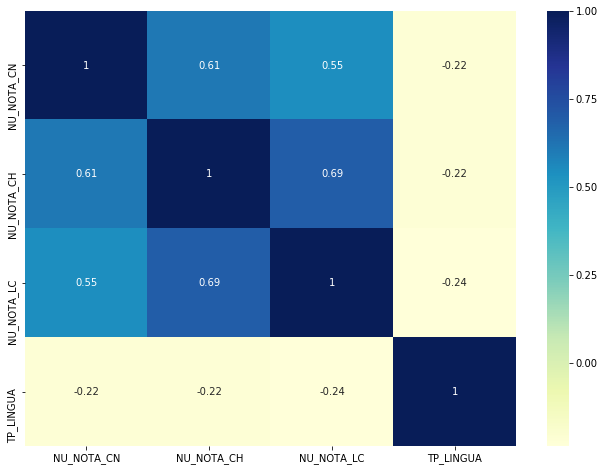

In [173]:
plt.figure(figsize=(11, 8))
sns.heatmap(X.corr(),  annot=True, annot_kws={"size": 10},cmap="YlGnBu");

# Modelos

In [151]:
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [153]:
xg_reg.score(X, y)

0.9542371816794438

In [157]:
y_pred = xg_reg.predict(df_test2)

In [162]:
df_result = pd.DataFrame() 
df_result['NU_INSCRICAO'] = df_test['NU_INSCRICAO']
df_result['NU_NOTA_MT'] = np.around(y_pred, 1)
df_result.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,432.799988
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,432.700012
2,b38a03232f43b11c9d0788abaf060f7366053b6d,619.200012
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,5.100000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,527.400024


In [163]:
df_result.to_csv('answer.csv', index=False, header=True)